In [1]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

### 1. Data load and split

In [35]:
def black_scholes_call_option(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    
    Parameters:
    S: Current stock price.
    K: Strike price of the option.
    T: Time to expiration in years.
    r: Risk-free interest rate (annualized).
    sigma: Volatility of the underlying stock (annualized).
    Returns:
        The Black-Scholes price of the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0) - 
                  K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call_price

def greeks(S, K, T, r, sigma):
    """
    Calculate the Greeks of a European call option using the Black-Scholes model.
    
    Parameters:
    S: Current stock price.
    K: Strike price of the option.
    T: Time to expiration in years.
    r: Risk-free interest rate (annualized).
    sigma: Volatility of the underlying stock (annualized).
    
    Returns:
        A dictionary containing the Greeks: Delta, Gamma, Vega, Theta, Rho.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    delta = si.norm.cdf(d1)
    gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * si.norm.pdf(d1) * np.sqrt(T)
    theta = (-S * si.norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - 
             r * K * np.exp(-r * T) * si.norm.cdf(d2))
    rho = K * T * np.exp(-r * T) * si.norm.cdf(d2)
    
    return {
        'Delta': delta,
        'Gamma': gamma,
        'Vega': vega,
        'Theta': -theta,
        'Rho': rho
    }

In [4]:
df = pd.read_csv('../data/processed/calls_2025_06_07.csv')
df_final = df[['price', 'strike', 'T', 'impliedVolatility', 'midPrice']].copy()

# Rename columns for clarity
df_final.rename(columns={
    'price': 'S',  # Current stock price
    'strike': 'K',  # Strike price
    'T': 'T',  # Time to expiration in years
    'impliedVolatility': 'sigma',  # Volatility of the underlying stock
    'midPrice': 'call_price'  # Black-Scholes price of the call option
}, inplace=True)

In [5]:
INPUTS = df_final.columns.drop('call_price').tolist()
TARGET = 'call_price'

X = df_final[INPUTS]
y = df_final[TARGET]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

### 2. MLP

##### NoGRIDSEARCH

In [201]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create the preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS)
])

# Create the full pipeline with best hyperparameters
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('MLP', MLPRegressor(
        hidden_layer_sizes=(60,),
        activation='tanh',
        alpha=0.001,
        learning_rate_init=0.01,
        solver='adam',
        max_iter=2000,
        tol=1e-4,
        random_state=150,
        verbose=True
    ))
])

# Fit the model
pipe.fit(X_train[INPUTS], y_train)

# Save the trained pipeline
joblib.dump(pipe, '../models/MLP_BSparams.pkl')

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


['../models/MLP_BSparams.pkl']

#### A. Train model

In [ ]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS)
        ])

param = {'MLP__alpha': [0.01], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(60,)],
         'MLP__learning_rate_init': [0.01],
         'MLP__activation': ['tanh']
}


pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='adam', 
                max_iter=2000, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS], y_train) # Search in grid


# Save the model
# import joblib
# joblib.dump(MLP_fit, '../models/MLP_simple_vs_BS_v2.pkl')

Iteration 1, loss = 11354.18338548
Iteration 1, loss = 11205.55116838
Iteration 2, loss = 8145.24611771
Iteration 2, loss = 8306.93127679
Iteration 3, loss = 6631.18255361
Iteration 1, loss = 11503.43655862
Iteration 3, loss = 6584.01263574
Iteration 1, loss = 11270.77232947
Iteration 1, loss = 11493.41598517
Iteration 1, loss = 11396.68224731
Iteration 1, loss = 11181.10169835
Iteration 1, loss = 11433.69098275
Iteration 2, loss = 8317.07499175
Iteration 4, loss = 5613.94893750
Iteration 4, loss = 5654.43728859
Iteration 2, loss = 8150.99919853
Iteration 2, loss = 8346.97718371
Iteration 2, loss = 8243.03446349
Iteration 2, loss = 8120.23067565
Iteration 2, loss = 8270.66438590
Iteration 5, loss = 4906.10277853
Iteration 3, loss = 6722.26043736
Iteration 5, loss = 4944.68608815
Iteration 3, loss = 6562.26910321
Iteration 3, loss = 6739.49238738
Iteration 3, loss = 6649.92100390
Iteration 3, loss = 6533.15153185
Iteration 3, loss = 6651.81762298
Iteration 6, loss = 4382.22457708
Iterat

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['S',
                                                                          'K',
                                                                          'T',
                                                                          'sigma'])])),
                                       ('MLP',
                                        MLPRegressor(max_iter=2000,
                                                     random_state=150,
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__activation': ['tanh'], 'MLP__alpha': [0.01],
                         'MLP__hidden_layer_sizes': [(60,)],
                         'MLP__learning_rate_init': [0.01]},
             scoring='neg_mean_squared_error')

#### B. Load Model

In [7]:
import joblib

# Cargamos el modelo guardado
MLP_fit = joblib.load('../models/MLP_simple_vs_BS.pkl')


### 3. MLP vs Black-Scholes

#### A. Graphic

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plotModelGridError(MLP_fit):
    results = MLP_fit.cv_results_
    mean_test_scores = results['mean_test_score']
    params = results['params']

    # Convertir a error (RMSE)
    errors = np.sqrt(-mean_test_scores)

    # Etiquetas incluyendo todos los hiperparámetros relevantes
    param_labels = [
        f"act: {p['MLP__activation']}, alpha: {p['MLP__alpha']}, size: {p['MLP__hidden_layer_sizes']}, lr: {p['MLP__learning_rate_init']}"
        for p in params
    ]

    # Obtener todos los learning rates únicos para codificarlos por color
    lrs = [p['MLP__learning_rate_init'] for p in params]
    unique_lrs = sorted(set(lrs))
    lr_color_map = {lr: cm.viridis(i / len(unique_lrs)) for i, lr in enumerate(unique_lrs)}
    bar_colors = [lr_color_map[lr] for lr in lrs]

    # Ordenar por error creciente
    sorted_indices = np.argsort(errors)
    errors_sorted = errors[sorted_indices]
    param_labels_sorted = [param_labels[i] for i in sorted_indices]
    bar_colors_sorted = [bar_colors[i] for i in sorted_indices]

    # Crear el gráfico
    plt.figure(figsize=(14, 8))
    bars = plt.barh(param_labels_sorted, errors_sorted, color=bar_colors_sorted)
    plt.xlabel("RMSE")
    plt.title("Model Grid Search Errors (RMSE), grouped by Learning Rate")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Crear leyenda manual
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color=lr_color_map[lr]) for lr in unique_lrs
    ]
    legend_labels = [f"lr: {lr}" for lr in unique_lrs]
    legend = plt.legend(legend_handles, legend_labels, title="Learning Rate", loc="upper right")

    # Quitar fondo de la leyenda
    legend.get_frame().set_facecolor('none')

    # Estética general
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
    
    plt.show()

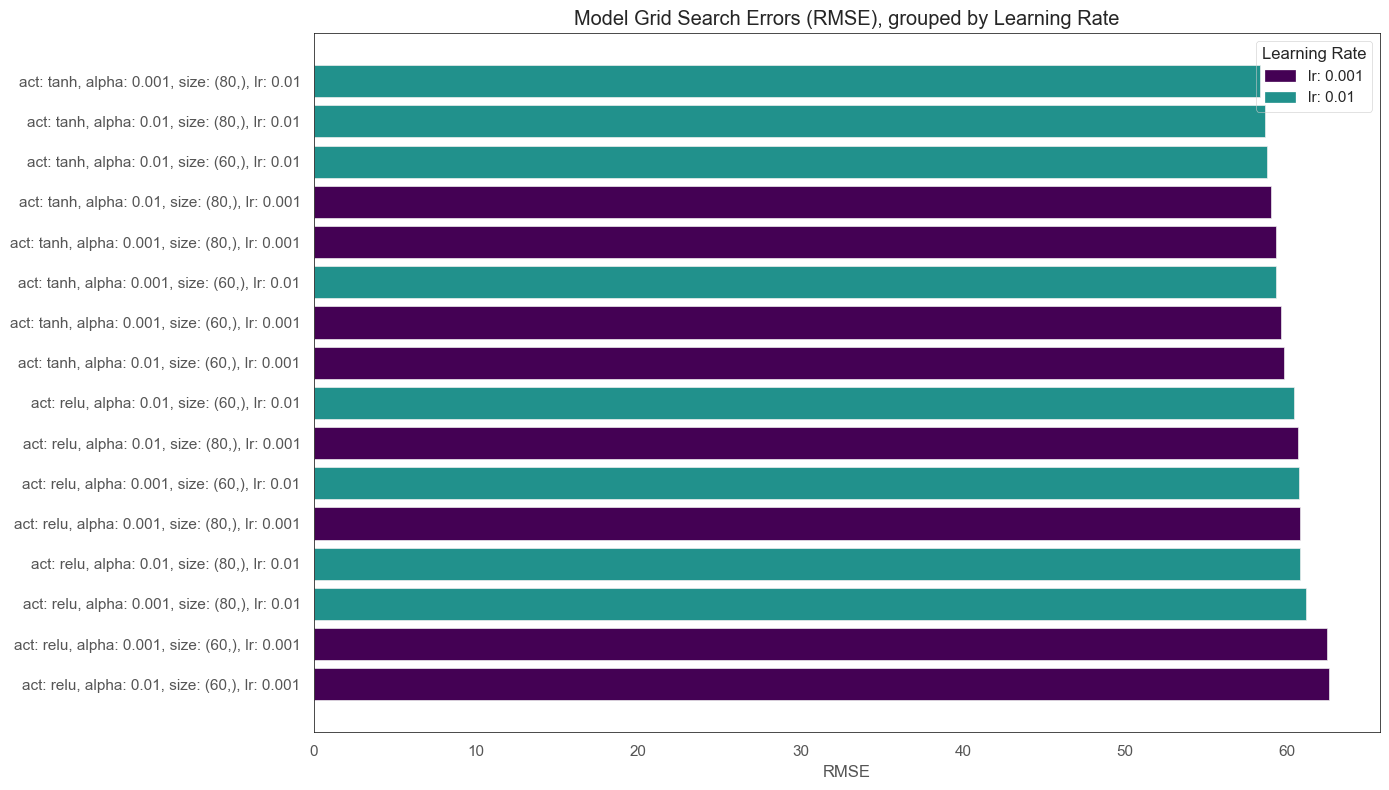

In [ ]:
plotModelGridError(MLP_fit)
# La mejor combinación es Tahn, alpha=0.01, size=(60,), lr=0.01

#### B. Comparison of metrics

In [8]:
# Calculate the predictions on the training set using Black-Scholes formula
dfTR_eval['BS_predict'] = black_scholes_call_option(
    dfTR_eval['S'],
    dfTR_eval['K'],
    dfTR_eval['T'],
    0.045,  # Assuming a risk-free interest rate of 5%
    dfTR_eval['sigma']
)

# Calculate the predictions on the test set using Black-Scholes formula
dfTS_eval['BS_predict'] = black_scholes_call_option(
    dfTS_eval['S'],
    dfTS_eval['K'],
    dfTS_eval['T'],
    0.045,  # Assuming a risk-free interest rate of 5%
    dfTS_eval['sigma']
)


In [9]:
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train[INPUTS])
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test[INPUTS])

In [10]:
#Training and test MAE - Mean Absolute error
print('MLP Predictions')
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))

MLP Predictions
Training MAE: 12.262899244235788
Test MAE: 12.505041779484985
Training RMSE: 52.78344537696626
Test RMSE: 57.393740442498
Training R2: 0.8935813491132577
Test R2: 0.8739427777236465


In [11]:
print('Black-Scholes Predictions')
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['BS_predict']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['BS_predict']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['BS_predict'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['BS_predict'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['BS_predict']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['BS_predict']))

Black-Scholes Predictions
Training MAE: 10.720614258601483
Test MAE: 10.757691945485645
Training RMSE: 80.39170301584045
Test RMSE: 87.16792037638447
Training R2: 0.7531434035458717
Test R2: 0.7092283612674393


#### C. Case to case comparison

In [12]:
import numpy as np
dfTR_eval['MLP_diff'] = np.abs(dfTR_eval['midPrice'] - dfTR_eval['MLP_pred'])
dfTR_eval['BS_diff'] = np.abs(dfTR_eval['midPrice'] - dfTR_eval['BS_predict'])
dfTR_eval['MLP_better'] = dfTR_eval['MLP_diff'] < dfTR_eval['BS_diff']

# Casos en los que MLP es mejor
mlp_better_cases = dfTR_eval[dfTR_eval['MLP_better']]
bs_better_cases = dfTR_eval[~dfTR_eval['MLP_better']]

# Diferencias de error entre ambos modelos
mlp_margin = bs_better_cases['BS_diff'] - bs_better_cases['MLP_diff']
bs_margin = mlp_better_cases['MLP_diff'] - mlp_better_cases['BS_diff']

# Estadísticas descriptivas
print("Test set:")
print("BS ha aproximado mejor que MLP en", len(bs_better_cases), "casos.")
print("   Media de mejora:", mlp_margin.mean())
print("   Mediana de mejora:", mlp_margin.median())

print("MLP ha aproximado mejor que BS en", len(mlp_better_cases), "casos.")
print("   Media de mejora:", bs_margin.mean())
print("   Mediana de mejora:", bs_margin.median())

Test set:
BS ha aproximado mejor que MLP en 77517 casos.
   Media de mejora: -8.790764806810275
   Mediana de mejora: -3.4626264136393323
MLP ha aproximado mejor que BS en 31927 casos.
   Media de mejora: -16.056625350385307
   Mediana de mejora: -2.202573008249793


In [13]:

dfTS_eval['MLP_diff'] = np.abs(dfTS_eval['midPrice'] - dfTS_eval['MLP_pred'])
dfTS_eval['BS_diff'] = np.abs(dfTS_eval['midPrice'] - dfTS_eval['BS_predict'])
dfTS_eval['MLP_better'] = dfTS_eval['MLP_diff'] < dfTS_eval['BS_diff']

# Casos en los que MLP es mejor
mlp_better_cases = dfTS_eval[dfTS_eval['MLP_better']]
bs_better_cases = dfTS_eval[~dfTS_eval['MLP_better']]

# Diferencias de error entre ambos modelos
mlp_margin = bs_better_cases['BS_diff'] - bs_better_cases['MLP_diff']
bs_margin = mlp_better_cases['MLP_diff'] - mlp_better_cases['BS_diff']

# Estadísticas descriptivas
print("Test set:")
print("BS ha aproximado mejor que MLP en", len(bs_better_cases), "casos.")
print("   Media de mejora:", mlp_margin.mean())
print("   Mediana de mejora:", mlp_margin.median())

print("MLP ha aproximado mejor que BS en", len(mlp_better_cases), "casos.")
print("   Media de mejora:", bs_margin.mean())
print("   Mediana de mejora:", bs_margin.median())

Test set:
BS ha aproximado mejor que MLP en 19434 casos.
   Media de mejora: -8.918183988945225
   Mediana de mejora: -3.496013178441032
MLP ha aproximado mejor que BS en 7927 casos.
   Media de mejora: -15.832818069017994
   Mediana de mejora: -2.2498256262705


/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


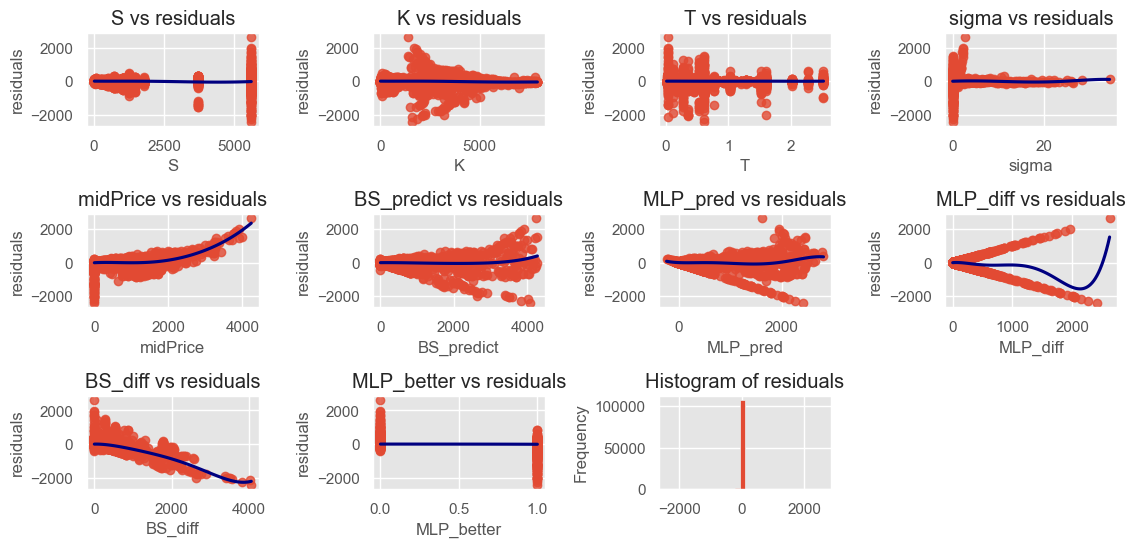

In [ ]:
from utils import plotModelDiagnosis
plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'midPrice')

### 4. Neuralsense

In [14]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS)


In [15]:
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=[TARGET])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [16]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y,)

In [17]:
sensmlp.summary()

Sensitivity analysis of [4, 80, 1] MLP network.

Sensitivity measures of each output:

$call_price 

                  mean         std  mean_squared
num__S      325.346297  179.186605    371.427048
num__K     -251.829046  169.082988    303.326434
num__T       37.006430   74.638737     83.309165
num__sigma  -35.789174  349.430367    351.258376


In [18]:
sensmlp.info()

Sensitivity analysis of [4, 80, 1] MLP network.

109444 samples

Sensitivities of each output (only 5 first samples):

$call_price 

       num__S      num__K      num__T  num__sigma
0  203.619707 -161.872469   35.025026    6.387379
1  204.739435  -66.805238  200.121530  -39.388661
2  199.183086  -97.764519   13.084808  -31.160425
3  332.691018 -189.963534   49.863294  254.187116
4  346.108650 -296.159507    6.498758   22.771691


/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


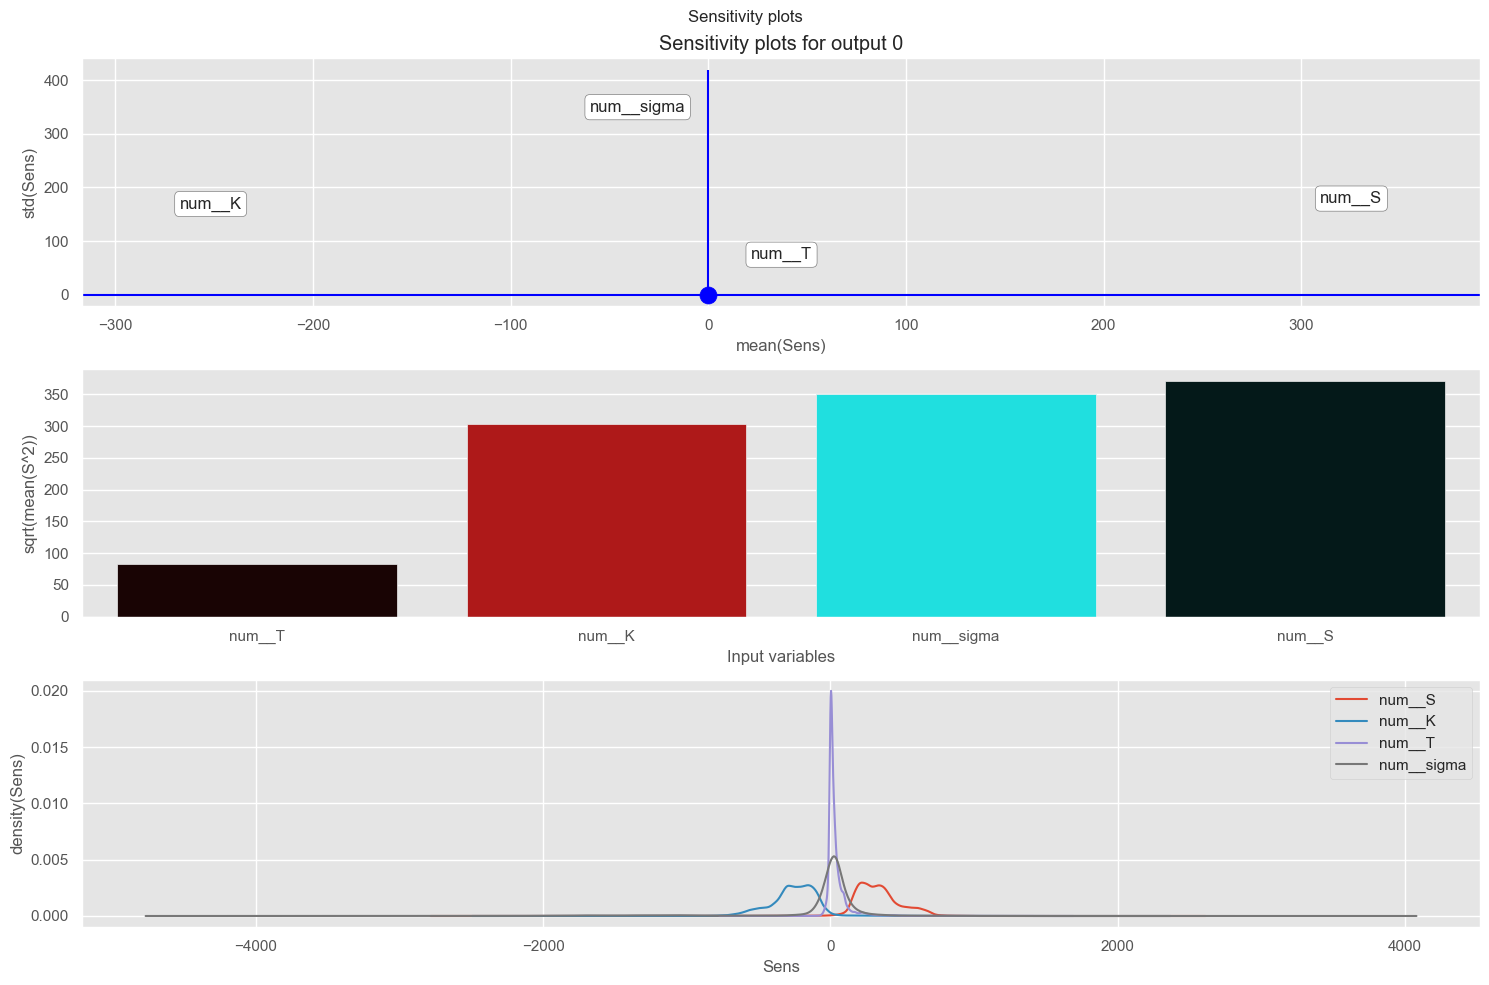

In [19]:
sensmlp.plot()

array([<Axes: xlabel='$\\alpha$', ylabel='$(ms_{X,j}^\\alpha(f))$'>,
       <Axes: >], dtype=object)

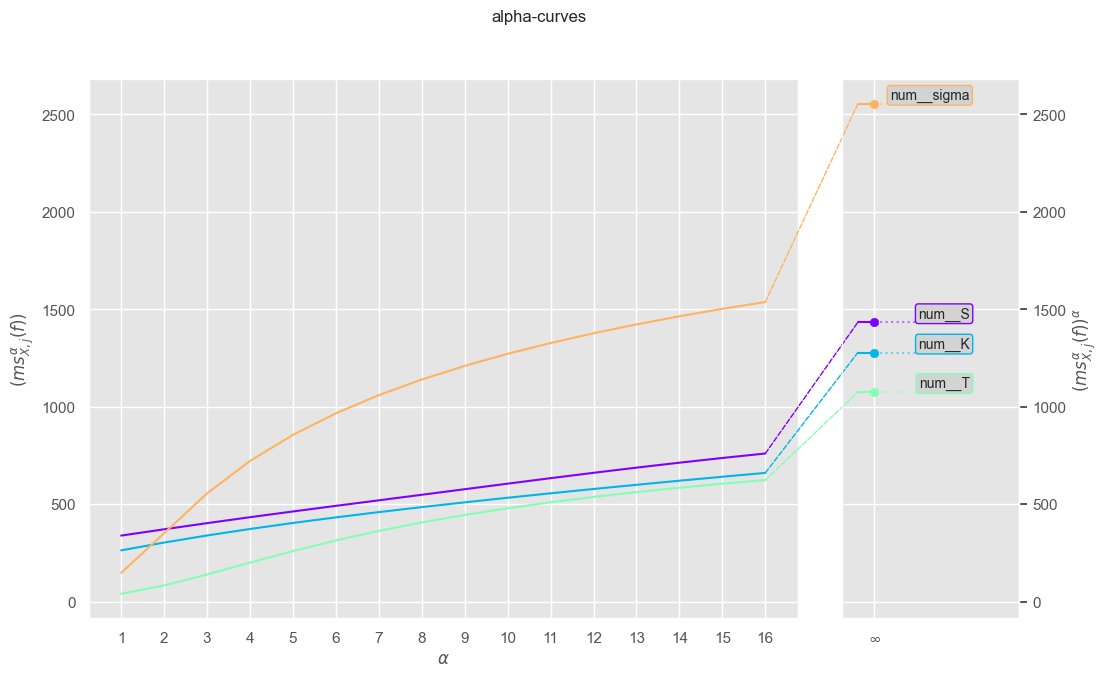

In [20]:
ns.alpha_sens_curves(sensmlp, figsize=(12, 7))

In [21]:
df_partDeriv = sensmlp.raw_sens[0]
df_partDeriv

,num__S,num__K,num__T,num__sigma
0,203.619707,-161.872469,35.025026,6.387379
1,204.739435,-66.805238,200.121530,-39.388661
2,199.183086,-97.764519,13.084808,-31.160425
3,332.691018,-189.963534,49.863294,254.187116
4,346.108650,-296.159507,6.498758,22.771691
...,...,...,...,...
109439,557.470674,-436.431986,28.313519,134.701887
109440,236.244093,-157.030451,203.562257,80.479959
109441,182.949724,-119.593475,0.885083,16.412884
109442,281.623618,-184.094043,102.893019,43.325021


Now it is necessary to descale the date because of the use of StandarScaler()

In [22]:
scaler = MLP_fit.best_estimator_['preprocessor'].transformers_[0][1].named_steps['scaler']
scales = scaler.scale_

# Supongamos que las columnas del neuralsense son:
# ['num__S', 'num__K', 'num__T', 'num__sigma']
columns = ['num__S', 'num__K', 'num__T', 'num__sigma']

# Desescalamos las derivadas:
for i, col in enumerate(columns):
    df_partDeriv[col + '_descaled'] = df_partDeriv[col] / scales[i]

In [23]:
df_partDeriv.describe()
df_partDeriv

,num__S,num__K,num__T,num__sigma,num__S_descaled,num__K_descaled,num__T_descaled,num__sigma_descaled
0,203.619707,-161.872469,35.025026,6.387379,0.328598,-0.270595,62.127375,10.774468
1,204.739435,-66.805238,200.121530,-39.388661,0.330405,-0.111675,354.975476,-66.442252
2,199.183086,-97.764519,13.084808,-31.160425,0.321438,-0.163428,23.209826,-52.562559
3,332.691018,-189.963534,49.863294,254.187116,0.536891,-0.317553,88.447487,428.772239
4,346.108650,-296.159507,6.498758,22.771691,0.558544,-0.495076,11.527493,38.412131
...,...,...,...,...,...,...,...,...
109439,557.470674,-436.431986,28.313519,134.701887,0.899636,-0.729563,50.222506,227.220130
109440,236.244093,-157.030451,203.562257,80.479959,0.381247,-0.262501,361.078635,135.756575
109441,182.949724,-119.593475,0.885083,16.412884,0.295241,-0.199919,1.569959,27.685860
109442,281.623618,-184.094043,102.893019,43.325021,0.454479,-0.307742,182.511589,73.082249


In [24]:
df_partDeriv.info()

print('Mean of partial derivatives:')
print(df_partDeriv.mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109444 entries, 0 to 109443
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   num__S               109444 non-null  float64
 1   num__K               109444 non-null  float64
 2   num__T               109444 non-null  float64
 3   num__sigma           109444 non-null  float64
 4   num__S_descaled      109444 non-null  float64
 5   num__K_descaled      109444 non-null  float64
 6   num__T_descaled      109444 non-null  float64
 7   num__sigma_descaled  109444 non-null  float64
dtypes: float64(8)
memory usage: 6.7 MB
Mean of partial derivatives:
num__S                 325.346297
num__K                -251.829046
num__T                  37.006430
num__sigma             -35.789174
num__S_descaled          0.525038
num__K_descaled         -0.420971
num__T_descaled         65.641988
num__sigma_descaled    -60.370504
dtype: float64


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_partial_derivative_distributions(df):
    """
    Dibuja histogramas con líneas de media y mediana para cada derivada parcial desescalada.
    
    Args:
        df (pd.DataFrame): DataFrame con columnas como num__S_descale, num__K_descale, etc.
    """
    # Filtramos solo columnas desescaladas
    cols = [col for col in df.columns if col.endswith('_descaled')]
    
    n_cols = len(cols)
    n_rows = (n_cols + 1) // 2  # dos columnas por fila
    
    plt.figure(figsize=(14, 5 * n_rows))
    
    for i, column in enumerate(cols, 1):
        plt.subplot(n_rows, 2, i)
        sns.histplot(df[column], kde=True, bins=100, color='steelblue')
        plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Mean: {df[column].mean():.2f}")
        plt.axvline(df[column].median(), color='green', linestyle=':', label=f"Median: {df[column].median():.2f}")
        
        # Extraemos el nombre original de la variable (S, K, T, sigma)
        feature_name = column.split('__')[-1].replace('_descaled','')
        plt.title(f"∂Price/∂{feature_name}")
        
        plt.xlabel("Partial derivative value")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

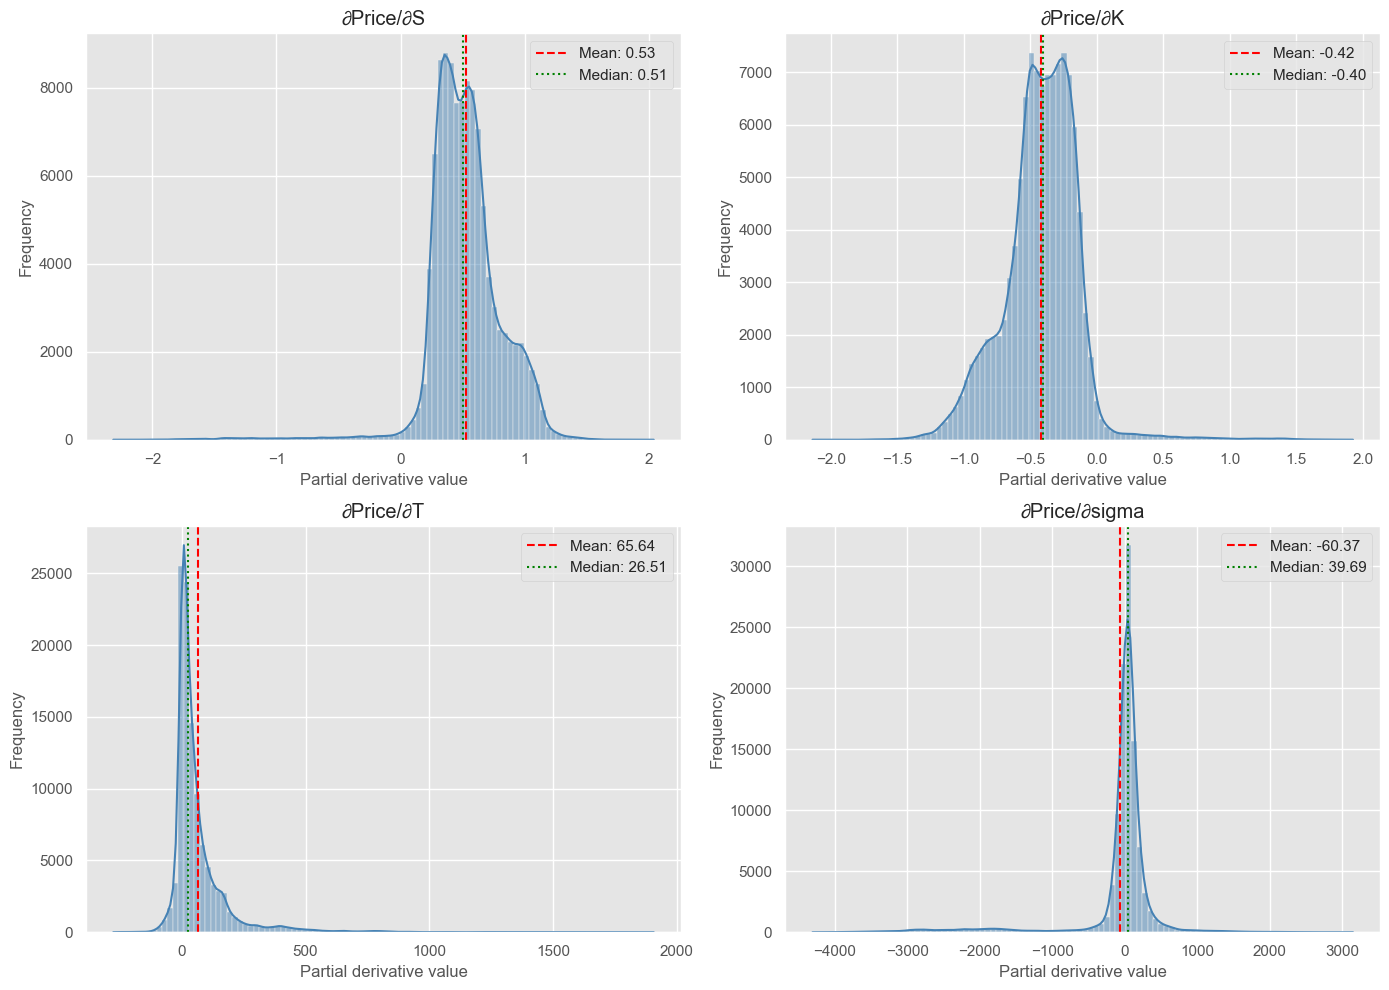

In [36]:
plot_partial_derivative_distributions(df_partDeriv)

In [ ]:
# Save the DataFrame with Training data with indexes
# Calcular Vega media
dfTR_eval_greeks = dfTR_eval.copy()
greeks_df = dfTR_eval_greeks.apply(
    lambda row: pd.Series(greeks(row['S'], row['K'], row['T'], 0.045, row['sigma'])),
    axis=1
)
dfTR_eval_greeks = pd.concat([dfTR_eval_greeks, greeks_df], axis=1)
dfTR_eval_greeks.to_csv('../data/predicted/dfTR_eval_greeks.csv', index=True)
dfTR_eval.to_csv('../data/predicted/dfTR_eval.csv', index=True)
df_partDeriv.to_csv('../data/predicted/df_partDeriv.csv', index=True)

In [ ]:
outliers_T = get_outliers_std(df_partDeriv, 'num__T', n_std=3)
outlier_rows_T = dfTR_eval.iloc[outliers_T.index]
# Display the outlier rows for T


# Store the outlier rows in a CSV file
outlier_rows_T.reset_index(drop=True).to_csv('../data/predicted/outliers_T.csv', index=False)


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

print("OUTLIERS de sigma")
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_sigma['midPrice'], outlier_rows_sigma['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_sigma['midPrice'], outlier_rows_sigma['MLP_pred'])))

print("OUTLIERS de T")
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_T['midPrice'], outlier_rows_T['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_T['midPrice'], outlier_rows_T['MLP_pred'])))

print("OUTLIERS de S")  
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_S['midPrice'], outlier_rows_S['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_S['midPrice'], outlier_rows_S['MLP_pred'])))

print("Numero de outliers de sigma:", len(outlier_rows_sigma))
print("Numero de outliers de T:", len(outlier_rows_T))
print("Numero de outliers de S:", len(outlier_rows_S))


OUTLIERS de sigma
	BS_diff RMSE: 161.89040831449233
	MLP_diff RMSE: 99.77888083095796
OUTLIERS de T
	BS_diff RMSE: 286.499021813977
	MLP_diff RMSE: 207.39905012548653
OUTLIERS de S
	BS_diff RMSE: 49.117329759204
	MLP_diff RMSE: 45.04007067790086
Numero de outliers de sigma: 4408
Numero de outliers de T: 2238
Numero de outliers de S: 1311


In [ ]:
# Sacar las filas que no son outliers pero de dfTR
non_outliers_sigma = dfTR_eval[~df_partDeriv.index.isin(outliers_sigma.index)]
non_outliers_T = dfTR_eval[~df_partDeriv.index.isin(outliers_T.index)]
non_outliers_S = dfTR_eval[~df_partDeriv.index.isin(outliers_S.index)]

print("NO OUTLIERS de sigma")
print("\tBS_diff medio:", non_outliers_sigma['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_sigma['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_sigma['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_sigma['MLP_diff'].median())

print("NO OUTLIERS de T")
print("\tBS_diff medio:", non_outliers_T['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_T['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_T['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_T['MLP_diff'].median())

print("NO OUTLIERS de S")
print("\tBS_diff medio:", non_outliers_S['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_S['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_S['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_S['MLP_diff'].median())


NO OUTLIERS de sigma
	BS_diff medio: 9.196119192502444
	BS_diff mediano: 1.0956680475914586
	MLP_diff medio: 11.18008293129198
	MLP_diff mediano: 3.763415612009164
NO OUTLIERS de T
	BS_diff medio: 9.785390521568596
	BS_diff mediano: 1.2112988581907675
	MLP_diff medio: 11.080126799177146
	MLP_diff mediano: 3.853686501924539
NO OUTLIERS de S
	BS_diff medio: 10.742066208280814
	BS_diff mediano: 1.2067094119571635
	MLP_diff medio: 12.04997194632072
	MLP_diff mediano: 3.8965364287153106


In [ ]:
# Calcular el mean de MLP_diff y BS_diff del dfTR_eval

print("\tBS_diff medio:", dfTS_eval['BS_diff'].mean())
print("\tBS_diff mediano:", dfTS_eval['BS_diff'].median())
print("\tMLP_diff medio:", dfTS_eval['MLP_diff'].mean())
print("\tMLP_diff mediano:", dfTS_eval['MLP_diff'].median())


	BS_diff medio: 10.757691945485645
	BS_diff mediano: 1.2022268983442839
	MLP_diff medio: 12.505041779484985
	MLP_diff mediano: 3.9419170025256456


In [ ]:
dfTR_eval_prueba = dfTR_eval.copy()
# Calcular las griegas de Black-Scholes para los datos de entrenamiento
# Quiero añadir cada griega como una columna en dfTR_eval_prueba
greeks_df = dfTR_eval_prueba.apply(
    lambda row: pd.Series(greeks(row['S'], row['K'], row['T'], 0.045, row['sigma'])),
    axis=1
)
# Añadir las griegas al DataFrame
dfTR_eval_prueba = pd.concat([dfTR_eval_prueba, greeks_df], axis=1)
# Mostrar las primeras filas del DataFrame con las griegas añadidas
dfTR_eval_prueba.head()


,S,K,T,sigma,midPrice,BS_predict,MLP_pred,MLP_diff,BS_diff,MLP_better,Delta,Gamma,Vega,Theta,Rho
131382,173.62,200.0,0.109589,0.512822,3.800,3.757710,10.692650,6.892650,0.042290,False,0.235989,0.010450,17.703292,-43.095964,4.078321
72057,86.35,144.0,0.032877,1.866212,1.480,1.076385,-0.601534,2.081534,0.403615,False,0.090486,0.005580,2.552729,-72.754641,0.221493
17838,133.13,375.0,0.608219,1.198002,13.300,13.717749,-3.331207,16.631207,0.417749,False,0.270277,0.002660,34.347227,-34.828554,13.541561
82834,697.71,670.0,1.528767,0.433653,158.375,178.790196,144.085476,14.289524,20.415196,True,0.681529,0.000954,307.881301,-57.019443,453.614506
60036,20.52,20.0,0.608219,0.420660,2.875,3.168233,6.509368,3.634368,0.293233,False,0.627675,0.056200,6.054556,-2.530768,5.906810


In [ ]:
# Calcular Vega media
vega_mean = dfTR_eval_prueba['Vega'].mean()

# calcular Delta media
delta_mean = dfTR_eval_prueba['Delta'].mean()

# Calcular Theta media
theta_mean = dfTR_eval_prueba['Theta'].mean()

print("Vega media:", vega_mean)
print("Delta media:", delta_mean)
print("Theta media:", theta_mean)



Vega media: 47.625760930858824
Delta media: 0.5428369310207808
Theta media: -40.1365250526288


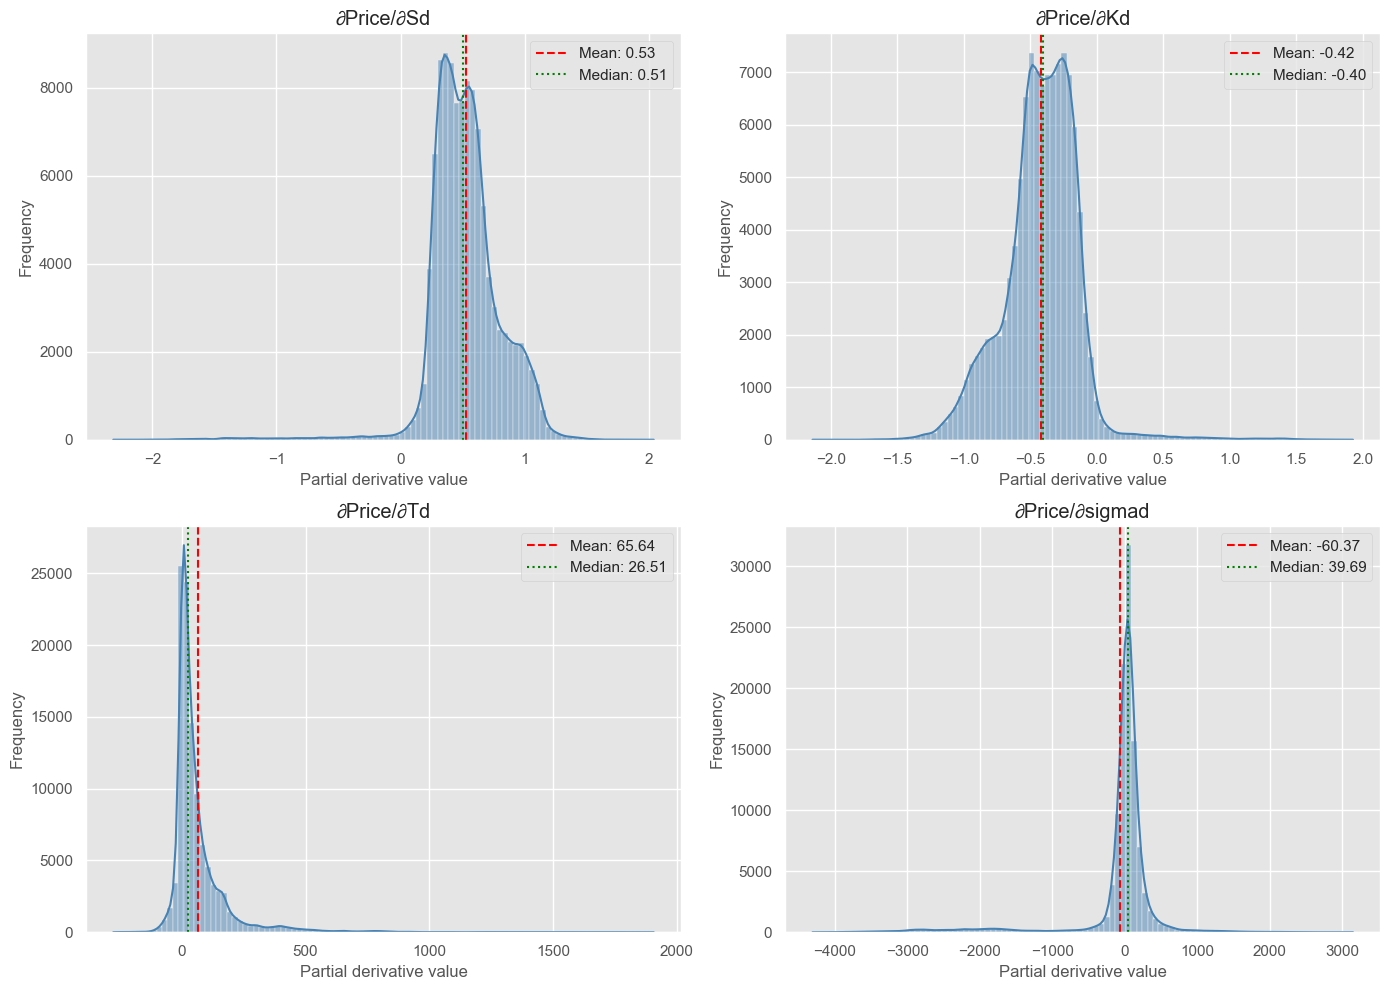

In [ ]:
plot_partial_derivative_distributions(df_partDeriv)

### Analisis de outliers de sigma

In [ ]:
outlier_rows_sigma

# Calculate greeks for the outliers
greeks_outliers_sigma = outlier_rows_sigma.apply(
    lambda row: pd.Series(greeks(row['S'], row['K'], row['T'], 0.045, row['sigma'])),
    axis=1
)
# Añadir las griegas al DataFrame de outliers
outlier_rows_sigma = pd.concat([outlier_rows_sigma, greeks_outliers_sigma], axis=1)
# Mostrar las primeras filas del DataFrame de outliers con las griegas añadidas
outlier_rows_sigma.head()

,S,K,T,sigma,midPrice,BS_predict,MLP_pred,MLP_diff,BS_diff,MLP_better,Delta,Gamma,Vega,Theta,Rho,Delta,Gamma,Vega,Theta,Rho
25108,198.14,55.0,0.608219,0.00001,133.4,144.624929,94.006589,39.393411,11.224929,False,1.0,0.0,0.0,-2.408178,32.548893,1.0,0.0,0.0,-2.408178,32.548893
46630,53.76,37.5,0.358904,0.00001,0.0,16.860786,17.674624,17.674624,16.860786,False,1.0,0.0,0.0,-1.660465,13.243280,1.0,0.0,0.0,-1.660465,13.243280
105590,170.34,155.0,0.186301,0.00001,0.0,16.634020,48.039198,48.039198,16.634020,False,1.0,0.0,0.0,-6.916769,28.635635,1.0,0.0,0.0,-6.916769,28.635635
20676,5614.61,3100.0,0.358904,0.00001,0.0,2564.274982,1665.026531,1665.026531,2564.274982,True,1.0,0.0,0.0,-137.265076,1094.777774,1.0,0.0,0.0,-137.265076,1094.777774
118719,167.10,87.5,0.531507,0.00001,33.8,81.667979,48.070726,14.270726,47.867979,True,1.0,0.0,0.0,-3.844441,45.407704,1.0,0.0,0.0,-3.844441,45.407704


In [ ]:
outlier_rows_sigma.mean()

S             364.772430
K             259.166096
T               0.551816
sigma           0.009987
midPrice       87.872637
BS_predict    134.919389
MLP_pred       94.744911
MLP_diff       38.064781
BS_diff        47.047035
MLP_better      0.480263
Delta           0.954773
Gamma           0.000351
Vega           17.274714
Theta         -11.351784
Rho           116.734476
Delta           0.954773
Gamma           0.000351
Vega           17.274714
Theta         -11.351784
Rho           116.734476
dtype: float64

In [ ]:
outliers_sigma.mean()

num__S                  167.910360
num__K                 -194.780634
num__T                    0.493818
num__sigma            -1357.331552
num__S_descaled           0.270971
num__K_descaled          -0.325606
num__T_descaled           0.875934
num__sigma_descaled   -2289.597116
dtype: float64

### Analisis de outliers de S (Delta)

In [ ]:
outlier_rows_S

,S,K,T,sigma,midPrice,BS_predict,MLP_pred,MLP_diff,BS_diff,MLP_better
39747,217.53,270.0,0.358904,0.062509,0.00,7.406839e-08,4.480155,4.480155,7.406839e-08,False
46630,53.76,37.5,0.358904,0.000010,0.00,1.686079e+01,17.674624,17.674624,1.686079e+01,False
78280,230.01,190.0,0.109589,0.000010,29.45,4.094468e+01,56.843859,27.393859,1.149468e+01,False
14124,97.25,640.0,1.605479,0.250007,0.00,6.643459e-08,43.680998,43.680998,6.643459e-08,False
54668,49.79,30.0,0.358904,0.000010,0.00,2.027063e+01,17.638841,17.638841,2.027063e+01,True
...,...,...,...,...,...,...,...,...,...,...
125899,465.64,560.0,0.780822,0.031260,0.00,7.676016e-08,132.643460,132.643460,7.676016e-08,False
66040,47.35,30.0,0.608219,0.000010,16.20,1.815996e+01,16.310129,0.110129,1.959961e+00,True
105983,100.23,140.0,1.605479,0.062509,0.00,1.120675e-03,13.950485,13.950485,1.120675e-03,False
124358,40.66,22.5,0.780822,0.000010,13.65,1.893685e+01,13.540218,0.109782,5.286854e+00,True
